In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

2021-11-01 15:54:51.454737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-11-01 15:54:52.161328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-01 15:54:52.217395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 15:54:52.217545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.807GHz coreCount: 28 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 335.32GiB/s
2021-11-01 15:54:52.217557: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-01 15:54:52.218711: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-01 15:54:52.218733: I tensorflow/stream_executor/pl

In [4]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)
#     except:
#         pass

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import librosa
import numpy as np
import random

In [7]:
import IPython
from scipy.io.wavfile import read,write
from pylab import plot,show,subplot,specgram, figure

## Utils

In [8]:
class PlotProgress(keras.callbacks.Callback):
    
    def __init__(self, entity='loss'):
        self.entity = entity
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('{}'.format(self.entity)))
        self.val_losses.append(logs.get('val_{}'.format(self.entity)))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="{}".format(self.entity))
        plt.plot(self.x, self.val_losses, label="val_{}".format(self.entity))
        plt.legend()
        plt.show();

In [9]:
def sliding(feature, window_size=120, stride=10, keep_last=True):
    length = feature.shape[1]
    count = 0
    result = []
    while length > 0:
        start = stride*count
        end = np.minimum(stride*count+window_size, feature.shape[1])
#         if not keep_last and (end - start < window_size) and (start - stride + window_size != feature.shape[1]):
#             break
        if not keep_last and (end - start < window_size):
            break
        feature_temp = feature[:, start:end, np.newaxis]
        length -= stride
        count += 1
        result.append(feature_temp)
        if end - start < window_size:
            break
    return result

In [10]:
def chop(feature, chop_length=500):
    length = feature.shape[1]
    if length < chop_length:
        diff = chop_length-length
        padding = np.zeros((feature.shape[0], diff, feature.shape[2]))
        return np.concatenate((feature, padding), axis=1)
    elif length >= chop_length:
        diff = length-chop_length
        return feature[:,(diff//2):(diff//2+chop_length),:]

## Load data

In [11]:
all_paths = []
all_label = []
with open("/home/hunglt16/reading_150/nam.txt") as f:
    all_files = f.readlines()
    for file in all_files:
        all_paths.append(file.split()[1])
        all_label.append(1)
with open("/home/hunglt16/reading_150/nu.txt") as f:
    all_files = f.readlines()
    for file in all_files:
        all_paths.append(file.split()[1])
        all_label.append(0)
print("total: {}".format(len(all_paths)))
x_train, x_val, y_train, y_val = train_test_split(all_paths, all_label, test_size=0.1)

total: 89085


[-0.00057983  0.00280762  0.00842285 ...  0.00259399  0.00311279
  0.00292969]
(86400,)


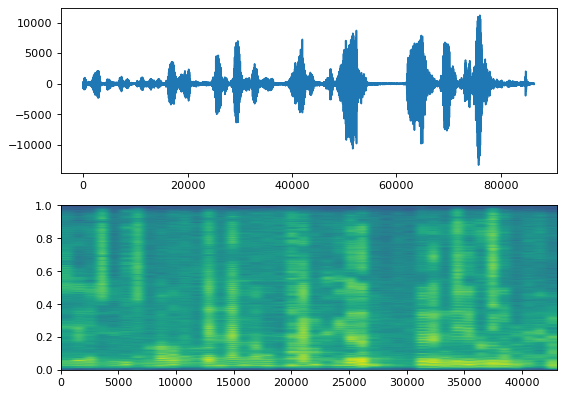

NAM


In [12]:
index = random.choice(range(len(all_paths))) 
file = all_paths[index]
label = all_label[index]
signal, _ = librosa.load(
    "/home/hunglt16/reading_150/"+file,
    sr=16000,
    mono=True,
    offset=0.0,
    res_type='kaiser_best',
)
print(signal)
print(signal.shape)

rate,data = read("/home/hunglt16/reading_150/"+file)

figure(figsize=(8, 6), dpi=80)
subplot(211)
plot(range(len(data)),data)
subplot(212)
specgram(data, NFFT=2048, noverlap=0)

show()
if label==0:
    print("NU")
else:
    print("NAM")
IPython.display.Audio("/home/hunglt16/reading_150/"+file)

In [13]:
def load_audio(root, file, n_mfcc=13):
    signal, _ = librosa.load(
        os.path.join(root, file),
        sr=16000,
        mono=True,
        offset=0.0,
        res_type='kaiser_best',
    )
    feature = librosa.feature.mfcc(
        signal,
        sr=16000,
        S=None,
        hop_length=160,
        n_mfcc=n_mfcc,
        dct_type=2,
        norm="ortho",
        lifter=0,
        n_mels=128,
        fmin=0.0,
        fmax=None,
        htk=False,
    )
    feature[feature == 0] = 0.000001
    feature[feature == -np.Inf] = -30
    feature[feature == np.NaN] = -30
    feature[feature == np.Inf] = 0
    feature = np.transpose(feature)
    feature = feature[np.newaxis,:,:]
    return feature

In [40]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_ids, labels, batch_size=128, time_step=500, dim=13,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.time_step = time_step
        self.dim = dim
        self.input_shape = (time_step, dim)
        self.batch_size = batch_size
        self.labels = labels
        self.list_ids = list_ids
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.list_ids))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of ids
        list_ids_temp = [self.list_ids[k] for k in indexes]
        list_labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_ids_temp, list_labels_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids_temp, list_label_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        # X = np.array([])
        # y = np.array([])
        X = np.empty((self.batch_size, *self.input_shape))
        y = np.empty(self.batch_size, dtype=int)

        # Generate data
        for i, (ID, label) in enumerate(zip(list_ids_temp, list_label_temp)):
            # Store sample
            x = load_audio(audio_path, ID, n_mfcc=self.dim)
            x = chop(x, chop_length=self.time_step)
            x[x == 0] = 0.000001
            x[x == -np.Inf] = -30
            x[x != x] = -30
            x[x == np.Inf] = 0
            X[i, ] = x
            # Store class
            y[i] = label
#             print(i)
#             print(ID)
#             print(label)
        print(X.shape)

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [41]:
batch_size=64
time_step=500
dim=13
n_classes=2

In [53]:
audio_path = "/home/hunglt16/reading_150"

training_generator = DataGenerator(x_train,
                                   y_train,
                                   batch_size=64,
                                   time_step=500,
                                   dim=13,
                                   n_classes=2)
validation_generator = DataGenerator(x_val, 
                                     y_val,
                                     batch_size=64,
                                     time_step=500,
                                     dim=13,
                                     n_classes=2)

In [45]:
for i in range(len(training_generator)):
    x = training_generator[i][0]
    
    pinf = np.any(x == np.Inf)
    ninf = np.any(x == -np.Inf)
    nan = np.any(x != x)
    
    if pinf or ninf or nan:
        print("Data error at {}".format(i))
    

(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 500, 13)
(64, 5

KeyboardInterrupt: 

## Model

In [18]:
from TDNN_layer import TDNNLayer

In [19]:
class StatsPooling(layers.Layer):
    def __init__(self):
        super(StatsPooling, self).__init__()
#         self.outputs = tf.Variable(initial_value=tf.zeros((2*input_dim,)), dtype=tf.float32, trainable=False)
#         self.outputs = tf.Variable(dtype=tf.float32, trainable=False) validate_shape is set to False

    def call(self, inputs):
        self.mean = tf.math.reduce_mean(inputs, axis=-2)
        self.std = tf.math.reduce_std(inputs, axis=-2)
#         self.outputs.assign(tf.concat([self.mean, self.std],2))
        self.outputs = tf.concat([self.mean, self.std],-1)
        return self.outputs

In [20]:
# def very_smol_nn(input_shape):
#     inputs = layers.Input(shape=input_shape)
#     x = TDNNLayer([-2, 2], sub_sampling=False, activation='relu')(inputs)
#     x = TDNNLayer([-2, 0, 2], sub_sampling=True, activation='relu')(x)
#     x = TDNNLayer([-3, 0, 3], sub_sampling=True, activation='relu')(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = StatsPooling()(x)
# #     mean = tf.math.reduce_mean(x)
# #     std = tf.math.reduce_std(x)
# #     stats_pooling = tf.stack((mean, std),1)
#     x = layers.Dense(128, activation='relu')(x)
#     outputs = layers.Dense(2, activation='softmax')(x)
#     model = models.Model(inputs, outputs, name='very_smol_nn')
#     return model

In [50]:
def very_smol_nn(batch_size, time_step, dim, n_classes=2):
    input_shape = (time_step, dim)
    inputs = layers.Input(shape=input_shape, batch_size=batch_size)
    x = layers.Conv1D(128, 15, strides=3, activation='relu', input_shape=input_shape)(inputs)
    x = layers.Conv1D(128, 5, strides=2, activation='relu', input_shape=input_shape)(x)
    x = layers.Conv1D(128, 3, strides=2, activation='relu', input_shape=input_shape)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = StatsPooling()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name='very_smol_nn')
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.99)
    opt = Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [51]:
model = very_smol_nn(batch_size, time_step, dim, n_classes)
model.summary()

Model: "very_smol_nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 500, 13)]           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (64, 162, 128)            25088     
_________________________________________________________________
conv1d_10 (Conv1D)           (64, 79, 128)             82048     
_________________________________________________________________
conv1d_11 (Conv1D)           (64, 39, 128)             49280     
_________________________________________________________________
dense_9 (Dense)              (64, 39, 128)             16512     
_________________________________________________________________
stats_pooling_3 (StatsPoolin (64, 256)                 0         
_________________________________________________________________
dense_10 (Dense)             (64, 128)                

In [23]:
checkpoint_dir = os.path.dirname(checkpoint_path)

callback = ModelCheckpoint(filepath=checkpoint_path,
                           monitor="val_loss",
                           save_best_only=True,
                           save_weights_only=True,
                           verbose=1)

In [54]:
history = model.fit(training_generator,
                    epochs=50, 
                    validation_data=validation_generator,
                    callbacks=[callback],
                    max_queue_size=32)

(64, 500, 13)
Epoch 1/50
(64, 500, 13)
  47/1252 [>.............................] - ETA: 13:17 - loss: 0.9338 - accuracy: 0.5258(64, 500, 13)


KeyboardInterrupt: 

In [55]:
for layer in model.layers: print(layer.get_config(), layer.get_weights())

{'batch_input_shape': (64, 500, 13), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_4'} []
{'name': 'conv1d_9', 'trainable': True, 'batch_input_shape': (None, 500, 13), 'dtype': 'float32', 'filters': 128, 'kernel_size': (15,), 'strides': (3,), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[[ 5.31707965e-02,  2.12206058e-02,  5.29059879e-02, ...,
          2.85823680e-02, -4.20433097e-02,  3.02630849e-02],
        [-4.49458212e-02,  4.13621850e-02, -3.87117341e-02, ...,
         -1.43853091e-02,  1.50850080e-02, -3.74415666e-02],
        [ 1.16277747e-02, -5.30901179e-02, -4.32638749e-02, ...,
          5.